# Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов
## Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.
## Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.


# План работы
1. [Открытие данных](#start)
2. [Подготовка данных](#preprocessing)
3. [Анализ данных](#adding)
4. [Проверка гипотез](#analysys)
    * [Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются](#hyp1)
    * [Гипотеза 2. Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов](#hyp2)
5. [Общие выводы](#conclusions)

<a id="start"><h1>1. Открытие данных</h1> </a>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt 
import seaborn as sns
import math

In [2]:
try:
    users_data = pd.read_csv('/datasets/users.csv')
    calls_data = pd.read_csv('/datasets/calls.csv')
    internet_data = pd.read_csv('/datasets/internet.csv')
    messages_data = pd.read_csv('/datasets/messages.csv')
    tariffs_data = pd.read_csv('/datasets/tariffs.csv')
except:
    users_data = pd.read_csv('users.csv')
    calls_data = pd.read_csv('calls.csv')
    internet_data = pd.read_csv('internet.csv')
    messages_data = pd.read_csv('messages.csv')
    tariffs_data = pd.read_csv('tariffs.csv')

# Описание данных
### Таблица users (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана


In [3]:
users_data.info()
users_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


### Таблица calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

In [4]:
calls_data.info()
calls_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


### Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

In [5]:
messages_data.info()
messages_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


### Таблица internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя


In [6]:
internet_data.info()
internet_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


### Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [7]:
tariffs_data.info()
tariffs_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Вывод по пункту 1
Пропусков в данных нет. Неверный формат даты во всех таблицах с датами. Необходимо округлить время звонков и мегабайты трафика в большую сторону в соответствии с условиями тарифов

<a id="preprocessing"><h1>2. Подготовка данных</h1> </a>

In [8]:
#переведем даты в формат datetime
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')
users_data['reg_date'] = pd.to_datetime(users_data['reg_date'], format='%Y-%m-%d')
users_data['churn_date'] = pd.to_datetime(users_data['churn_date'], format='%Y-%m-%d')

In [9]:
#если дата ухода пуста, то до конца 2018 он остался на тарифе
users_data['churn_date'].fillna('2019-01-01', inplace=True) 


In [10]:
#добавляем столбец month (кроме таблицы users)
calls_data['month'] = pd.to_datetime(calls_data['call_date']).dt.month
messages_data['month'] = pd.to_datetime(messages_data['message_date']).dt.month
internet_data['month'] = pd.to_datetime(internet_data['session_date']).dt.month

In [11]:
#Округлим звонки и мегабайты в большую сторону (т.к. тариф считается по минутам и по мегабайтам)
#calls_data['duration'] = calls_data['duration'].apply(np.ceil).replace(0, 1)
#internet_data['mb_used'] = internet_data['mb_used'].apply(np.ceil).replace(0, 1)

In [12]:
calls_data['duration'] = np.ceil(calls_data['duration'])
calls_data['duration'] 

0          0.0
1          0.0
2          3.0
3         14.0
4          6.0
          ... 
202602     1.0
202603    19.0
202604    11.0
202605     5.0
202606    20.0
Name: duration, Length: 202607, dtype: float64

In [13]:
#в таблице с трафиком переведем мб в гб
internet_data['gb_used'] = (internet_data['mb_used'] / 1024)
internet_data.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month,gb_used
0,0,1000_0,112.95,2018-11-25,1000,11,0.110303
1,1,1000_1,1052.81,2018-09-07,1000,9,1.028135
2,2,1000_2,1197.26,2018-06-25,1000,6,1.169199
3,3,1000_3,550.27,2018-08-22,1000,8,0.537373
4,4,1000_4,302.56,2018-09-24,1000,9,0.295469


### Посчитаем для каждого пользователя:

количество сделанных звонков и израсходованных минут разговора по месяцам;<br>
количество отправленных сообщений по месяцам;<br>
объем израсходованного интернет-трафика по месяцам;<br>
помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).<br>
Для этого составим сводные таблицы.

In [14]:
users_messages = messages_data.merge(users_data, on='user_id', how='inner')
messages_grouped = users_messages.pivot_table(values='id', 
                       index=['user_id', 'month',], 
                       aggfunc={'user_id': 'count'})
messages_grouped.columns = ['messages']
messages_grouped.head()

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57

In [15]:
users_calls = calls_data.merge(users_data, on='user_id', how='inner')
calls_grouped = users_calls.pivot_table(values=['duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'user_id': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']
calls_grouped.head()

duration  calls
user_id month                 
1000    5         159.0     22
        6         172.0     43
        7         340.0     47
        8         408.0     52
        9         466.0     58

In [16]:
users_internet = internet_data.merge(users_data, on='user_id', how='inner')
internet_grouped = users_internet.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
#internet_grouped['mb_used'] = internet_grouped['mb_used'].apply(np.ceil).replace(0, 1)
#сюда перенесла округление по мб

#Исправление №2:
internet_grouped['gb_used'] = np.ceil(internet_grouped['mb_used'] / 1024)

internet_grouped.columns = ['mb_used','gb_used']
#и перевод в Гб тоже 
internet_grouped.head()

mb_used  gb_used
user_id month                   
1000    5       2253.49      3.0
        6      23233.77     23.0
        7      14003.64     14.0
        8      14055.93     14.0
        9      14568.91     15.0

In [17]:
megaline = calls_grouped.merge(messages_grouped, how='outer', on=['user_id', 'month'])
megaline = megaline.merge(internet_grouped, how='outer', on=['user_id', 'month'])
megaline.reset_index(level=[0,1], inplace=True)
megaline.head()

,user_id,month,duration,calls,messages,mb_used,gb_used
0,1000,5,159.0,22.0,22.0,2253.49,3.0
1,1000,6,172.0,43.0,60.0,23233.77,23.0
2,1000,7,340.0,47.0,75.0,14003.64,14.0
3,1000,8,408.0,52.0,81.0,14055.93,14.0
4,1000,9,466.0,58.0,57.0,14568.91,15.0


Создана общая таблица `megaline`. Добавим в нее столбец с тарифами и проверим на пропуски

In [18]:
megaline = megaline.merge(users_data[['user_id', 'tariff']], on='user_id', how='left')
megaline

,user_id,month,duration,calls,messages,mb_used,gb_used,tariff
0,1000,5,159.0,22.0,22.0,2253.49,3.0,ultra
1,1000,6,172.0,43.0,60.0,23233.77,23.0,ultra
2,1000,7,340.0,47.0,75.0,14003.64,14.0,ultra
3,1000,8,408.0,52.0,81.0,14055.93,14.0,ultra
4,1000,9,466.0,58.0,57.0,14568.91,15.0,ultra
...,...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17206.30,17.0,smart
3210,1489,10,NaN,NaN,21.0,19559.44,20.0,smart
3211,1489,11,NaN,NaN,20.0,17491.56,18.0,smart
3212,1489,12,NaN,NaN,35.0,17322.51,17.0,smart


Пропуски появились за счет того, что некоторые пользователи в какие-то месяцы не пользовались некоторыми услугами, например, Интернетом. Заполним эти пропуски нулями.

In [19]:
megaline.loc[megaline['duration'].isna(), 'duration'] = 0
megaline.loc[megaline['messages'].isna(), 'messages'] = 0
megaline.loc[megaline['mb_used'].isna(), 'mb_used'] = 0
megaline.loc[megaline['calls'].isna(), 'calls'] = 0
megaline

,user_id,month,duration,calls,messages,mb_used,gb_used,tariff
0,1000,5,159.0,22.0,22.0,2253.49,3.0,ultra
1,1000,6,172.0,43.0,60.0,23233.77,23.0,ultra
2,1000,7,340.0,47.0,75.0,14003.64,14.0,ultra
3,1000,8,408.0,52.0,81.0,14055.93,14.0,ultra
4,1000,9,466.0,58.0,57.0,14568.91,15.0,ultra
...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17206.30,17.0,smart
3210,1489,10,0.0,0.0,21.0,19559.44,20.0,smart
3211,1489,11,0.0,0.0,20.0,17491.56,18.0,smart
3212,1489,12,0.0,0.0,35.0,17322.51,17.0,smart


Напишем функцию для определения оплаты по тарифу. 

In [20]:
def payment(row):
    
    messages=row['messages']
    calls=row['duration']
    internet=row['mb_used']
    tariff=row['tariff']
    
 #в зависимости от тарифа, оплата вычисляется по разному:   
    if (tariff=='smart'):
        i=0
    else:
        i=1
        
    remain_call=tariffs_data['minutes_included'][i]-calls
    if remain_call<0:
        call_pay=-remain_call*tariffs_data['rub_per_minute'][i]
    else:
        call_pay=0
         
    remain_internet=tariffs_data['mb_per_month_included'][i]-internet
    if remain_internet<0:
#        internet_pay=round((-remain_internet/1024))*tariffs_data['rub_per_gb'][i]
        internet_pay=math.ceil((-remain_internet/1024))*tariffs_data['rub_per_gb'][i]
    else:
        internet_pay=0
            
    remain_messages=tariffs_data['messages_included'][i]-messages
    if remain_messages<0:
        messages_pay=-remain_messages*tariffs_data['rub_per_message'][i]
    else:
        messages_pay=0
            
    pay=call_pay+internet_pay+messages_pay+tariffs_data['rub_monthly_fee'][i]
    return pay  

In [21]:
megaline['payment'] = megaline.apply(payment, axis=1)
megaline.head(10)  

,user_id,month,duration,calls,messages,mb_used,gb_used,tariff,payment
0,1000,5,159.0,22.0,22.0,2253.49,3.0,ultra,1950.0
1,1000,6,172.0,43.0,60.0,23233.77,23.0,ultra,1950.0
2,1000,7,340.0,47.0,75.0,14003.64,14.0,ultra,1950.0
3,1000,8,408.0,52.0,81.0,14055.93,14.0,ultra,1950.0
4,1000,9,466.0,58.0,57.0,14568.91,15.0,ultra,1950.0
5,1000,10,350.0,57.0,73.0,14702.49,15.0,ultra,1950.0
6,1000,11,338.0,43.0,58.0,14756.47,15.0,ultra,1950.0
7,1000,12,333.0,46.0,70.0,9817.61,10.0,ultra,1950.0
8,1001,11,430.0,59.0,0.0,18429.34,18.0,smart,1150.0
9,1001,12,414.0,63.0,0.0,14036.66,14.0,smart,550.0


<a id="adding"><h1>3. Анализ данных</h1> </a>

Опишем поведение клиентов оператора, исходя из выборки. Определим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

In [22]:
month_data = megaline.pivot_table(
    index=['tariff', 'month'],
    values=['duration', 'messages', 'mb_used', 'payment']
)

In [23]:
smart_per_month = month_data.loc['smart']
smart_per_month

,duration,mb_used,messages,payment
month,,,,
1,203.852941,8513.717647,18.235294,721.323529
2,298.689655,11597.054310,24.086207,827.603448
3,390.051948,15104.159091,31.857143,1164.623377
4,367.133929,13462.180625,30.741071,963.089286
5,387.361702,15805.184326,33.773050,1197.510638
6,395.640244,15794.647988,33.402439,1204.018293
7,408.353234,15743.150348,33.751244,1223.950249
8,421.468085,16610.720085,33.638298,1320.595745
9,428.611538,16303.578808,33.638462,1249.946154


In [24]:
ultra_per_month = month_data.loc['ultra']
ultra_per_month

,duration,mb_used,messages,payment
month,,,,
1,428.111111,13140.681111,33.777778,1950.000000
2,297.125000,11775.937500,21.958333,1975.000000
3,489.648649,17535.550270,32.297297,2014.864865
4,458.018182,16828.134364,31.563636,2001.818182
5,510.328358,19363.152985,37.850746,2059.701493
6,479.702381,18924.939286,41.726190,2039.285714
7,545.791209,20495.665165,49.846154,2118.131868
8,510.775701,19576.054673,48.439252,2083.177570
9,539.443478,19204.277130,52.286957,2024.347826


In [25]:
tariff_usage = month_data.pivot_table(
    index='tariff',
    values=['duration', 'messages', 'mb_used', 'payment']
)
tariff_usage

,duration,mb_used,messages,payment
tariff,,,,
smart,386.760499,15058.406234,31.413211,1179.924424
ultra,495.934310,18205.809571,43.714983,2046.932856


Из таблицы видно, что на тарифе Ультра пользователи более активны, и компании выгоднее Ультра с точки зрения прибыли. Для пользователя выгоднее тариф Смарт.

In [26]:
stats = megaline.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages', 'payment'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std],
                             'messages': [np.median, np.var, np.std],
                             'payment': [np.median, np.var, np.std, np.mean]})
stats

duration                              mb_used                \
         median         std            var    median           std   
tariff                                                               
smart     422.0  190.313730   36219.315784  16506.84   5870.476681   
ultra     518.0  317.606098  100873.633397  19308.01  10087.170752   

                     messages                              payment          \
                 var   median        std          var         mean  median   
tariff                                                                       
smart   3.446250e+07     28.0  28.227876   796.812958  1289.973531  1023.0   
ultra   1.017510e+08     38.0  47.804457  2285.266143  2070.152284  1950.0   

                                   
               std            var  
tariff                             
smart   818.404367  669785.708006  
ultra   376.187114  141516.745079

Построим гистограммы и "ящики с усами" по тарифам

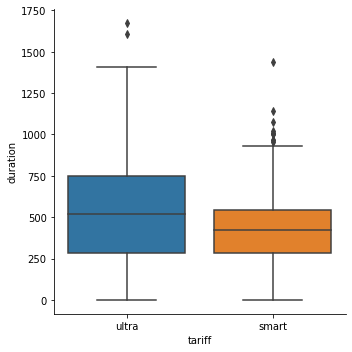

In [27]:
sns.catplot(x="tariff", y='duration', kind="box", data=megaline, orient='v')

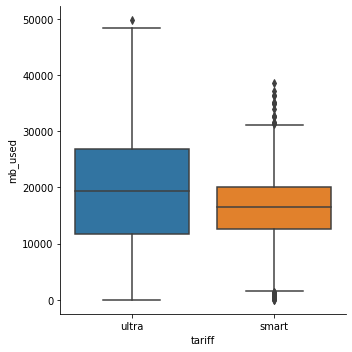

In [28]:
sns.catplot(x="tariff", y='mb_used', kind="box", data=megaline, orient='v')

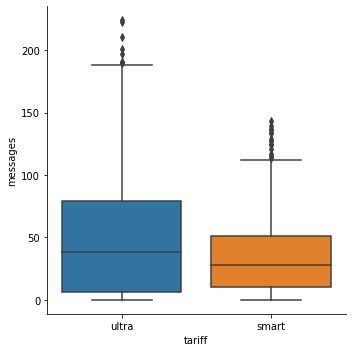

In [29]:
sns.catplot(x="tariff", y='messages', kind="box", data=megaline, orient='v')

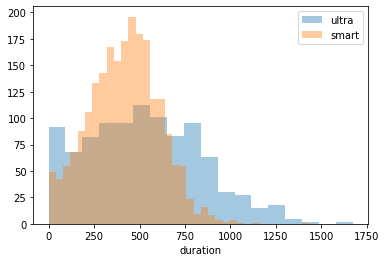

In [30]:
for tariff in (['ultra', 'smart']):
    sns.distplot(megaline.query('tariff == @tariff')['duration'], kde=False)
_ = plt.legend(['ultra', 'smart'])

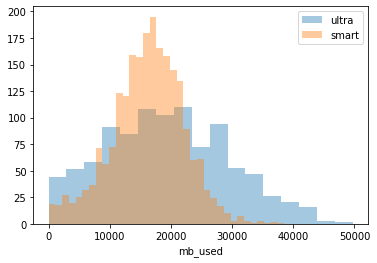

In [31]:
for tariff in (['ultra', 'smart']):
    sns.distplot(megaline.query('tariff == @tariff')['mb_used'], kde=False)
_ = plt.legend(['ultra', 'smart'])

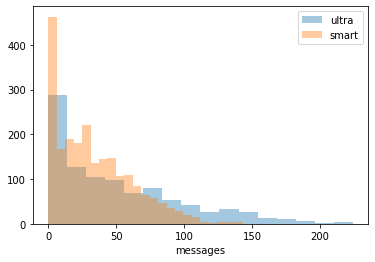

In [32]:
for tariff in (['ultra', 'smart']):
    sns.distplot(megaline.query('tariff == @tariff')['messages'], kde=False)
_ = plt.legend(['ultra', 'smart'])

Отображенные гистаграммы показывают, что дисперсия по "Ультра" больше, чем у пользователей с тарифом "Смарт". Пользователи тарифа Смарт явно себя ограничивают

<div class="alert alert-block alert-info">

В тарифе smart подавляющее большинство абонентов укладываются в лимит 500 минут разговора (среднее значение за 2018 год - 421 минута), но и в тарифе ultra не сильно ушли от этого значения - среднемесячное не больше 600 минут (не говоря уже об излишнем лимите в 3000! ). По СМС (малопопулярная услуга,  много абонентов которых вообще не пишут СМС или почти не пишут): абоненты тарифа smart вполне укладываются в лимит 50 СМС (а среднее 28 СМС в месяц за год), даже абоненты тарифа ultra редко превышают порог в 50 СМС (скорее всего это какие-то интернет-сервисы или магазины). По интернет-трафику: абоненты smart часто привышают лимитв 15360 МБ, даже среднее значение выше - 16073 МБ; средний расход трафика на smart довольно невысокий не смотря на порог в 30 ГБ средний расход около 18,8 ГБ. Подавляющее большинство абонентов расходуют в месяц трафика от 11 до 23 ГБ
Вывод по оплате: выручка от абонентов ultra в подавляющем большинстве случаев ограничивается абонплатой(1950р), а абоненты smart часто платят сверх абонплаты ( 982 - 550 =  482р) - на 87,5% больше абонентской платы!
</div>


<a id="hyp1"> <h1> 4. Проверка гипотез </h1></a>

<a id="analysys">Гипотеза 1. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются</a> <br>
H0 - гипотеза : средние наших выборок равны.<br>
H1 - гипотеза : cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [33]:
alpha = 0.05
ultra = ultra_per_month['payment']
smart = smart_per_month['payment']
results = st.ttest_ind(smart, ultra, equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 3.2027925855703315e-08
Отвергаем нулевую гипотезу


Значение p-lavue свидетельствует о малой вероятности случайного совпадения средних по тарифам. Значит, нулевую гипотезу можно отвергнуть и сказать, что с 95% вероятностью средние значения выручки по тарифам не совпадут.

<a id="hyp2">Гипотеза 2. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются</a><br>
H0 - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.
<br>
H1 - средняя выручка пользователей из Москвы отличается средней выручке пользователей из других регионов.

In [34]:
#создадим две таблицы, в одной будут все клиенты из москвы, во второй - все остальные
citys = megaline.merge(users_data.loc[: , ['user_id', 'city']], on='user_id')

moscow = citys.query('city == "Москва"')['payment']
regions = citys.query('city != "Москва"')['payment']

alpha = 0.05
results = st.ttest_ind(moscow, regions, equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


<a id="conclusions"><h1>5. Общие выводы</h1> </a>

Доходы от тарифа  больше, чем от тарифа «Смарт». Кроме того, не все пользователи тарифа «Ультра» тратят доступный им лимит. Доплат по тарифу «Ультра» очень мало. В тарифе «Смарт» часто доплачивают за дополнительные пакеты интернета. Количество пользователей таррифа «Смарт» больше в 2 раза, что можно объяснить более выгодными условиями для пользователей. 
В целом для оператора выгоднее тариф «Ультра».